## RNN 成立的原则是，过去的经验对现在的决策有益。

### $ P(x_1,x_2,...,x_t) = P(x_1) * P(x_2|x_1) * P(x_3|x_2,x_1) * ... * P(x_t|x_{t-1},...,x_1)$

但随着 `num(data)`的增长，计算难度也在增长（要连乘 $t$ 次）。实际中，一百万条数据很常见，但做一百万次连乘开销太大。

### 1.隐马尔可夫模型
因此一种简化方案是只看最近的 $ \gamma $ 个元素，这样一来不论多少条数据，只需连乘 $\gamma$ 次。即
> $\gamma$ 阶马尔可夫模型。

### 2.隐变量模型用 $h_t$ 概括历史信息
描述过去的信息 $h_t = f(x_1,...,x_{t-1})$

## 1.训练

### （1）使用正弦函数和一些可加性噪声来生成序列数据

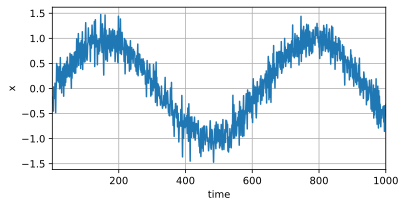

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

### （2）将这个序列转换为模型的特征－标签（feature-label）对
tau 决定了 featurs 的数量，即指明用 tau 个元素预测紧随其后的 label 值
tau = 4:
0,1,2,3|4
1,2,3,4|5
...
i,i+1,i+2,i+3|i+4

常识可知，常规范围内 tau 越大越好。正如知道越久远的历史股价，越能准确预测明日股价

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))  # 996 * 4
# 按列遍历，塞入(0:996),(1:997),(2:998),(3:999)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))       # 996 * 1

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

### （3）一个简单的训练模型，拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1)
    )
    net.apply(init_weights)

    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

### （4）训练函数

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

C:\temp\ipykernel_14076\3077141453.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


epoch 1, loss: 0.064214
epoch 2, loss: 0.055588
epoch 3, loss: 0.056006
epoch 4, loss: 0.056650
epoch 5, loss: 0.065510


## 2.预测
### (1).单步预测，模型预测当前 features 序列后 紧跟着的 1 个时序元素

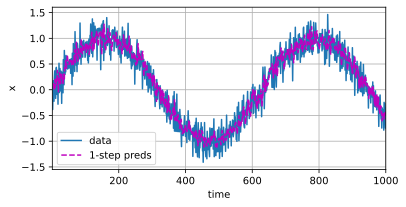

In [11]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

### 多步预测，给定 a 个点预测将来 N 个点，显然要求预测的越多准确率越低
总之，越遥远的未来越难预测，接下来学习如何优化模型，以达到这个困难的目的。